<a href="https://colab.research.google.com/github/trad777/AL/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22TNN_demo_ru_v2_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# НЕЙРОСЕТИ И ТРЕЙДИНГ (проект [TradingNN](https://tradingnn.com))

Цель: продемонстрировать возможность прогноза движения цены используя общедоступные нейросетевые библиотеки.

Что будет сделано:
1. Загружены уже обученные модели.
2. Загружен массив последних актуальных данных по торговой паре BTC/USD для опроса моделей.
3. Произведен опрос и обработка ответов моделей.
4. Произведена отрисовка сигналов на графике торговой пары.

⚡ Данные с биржи в реальном времени! Прогноз актуальный!

Вопросы и пожелания отправляйте [@mvbsp](https://t.me/mvbsp)

#1. Подготовка
👇 кликните по кружку со стрелкой, это запустит процесс подготовки данных

In [6]:
# начинаем с подключения нужных библиотек
!pip install matplotlib
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import os.path, warnings, zipfile, shutil, requests
from IPython.display import clear_output
from datetime import datetime
from google.colab import files
%matplotlib inline
warnings.filterwarnings('ignore')


# эта функция скачает готовые модели
def get_models():
  if os.path.exists("/content/models.zip") and os.path.exists("/content/models") == False:
    print("✅️ Модели уже есть, загружать не надо. Все готово, можно двигаться дальше.")
    with zipfile.ZipFile("/content/models.zip", "r") as zip_ref:
      zip_ref.extractall()
  else:
    for file_object in os.listdir('/content'):
      file_object_path = os.path.join('/content', file_object)
      if os.path.isfile(file_object_path): os.unlink(file_object_path)
      else: shutil.rmtree(file_object_path)
    clear_output(wait=True)
    print("\n🕒 Идет загрузка моделей...\n")
    u = "https://colab.tradingnn.com/models.zip"
    f = requests.get(u, allow_redirects=True)
    open('models.zip', 'wb').write(f.content)
    if os.path.exists("models.zip"):
      with zipfile.ZipFile("/content/models.zip", "r") as zip_ref:
          zip_ref.extractall()
      print("✅️ Модели загружены в директорию /content, все готово.\n")
    else:
      print("⚠️️ Проблема с загрузкой, что то пошло не так.")
      raise SystemExit


# эта функция заберет последние 3000 свечей 6M BTC/USDT а так же данные для опроса моделей
def get_from_tnn():
  r = requests.post("https://colab.tradingnn.com/live_for_colab.php").text
  d = r.split("|")
  size = np.fromstring(d[0], sep=",").shape[0]
  data = np.empty(shape=[1, size])
  for dt in d:
    m = np.array([np.fromstring(dt, sep=",")])
    if m.shape[1] == 92: data = np.append(data, m, axis=0)
  return data, size


# эта функция вернет массив с названиями моделей
def models_list():
  f_list = os.listdir(path="/content/models")
  model_path_arr = np.empty(shape=[0, 1])
  for i, model_ in enumerate(f_list):
    model_path_arr = np.append(model_path_arr, [[model_]], axis=0)
  return model_path_arr


# вынимаем из названия модели верхний и нижний лимиты
def get_model_res(model_):
    st = model_[:-3]
    st = st.split("_")
    symbol_ = st[0]
    timeframe_ = st[1]
    lim_up_ = float(st[2])
    lim_down_ = float(st[3])
    return lim_up_, lim_down_


# подготовка массивов для рисования
def plot_arr(results, res, lim):
  u = d = np.empty(shape=[0, 2])
  win = lose = 0
  for j, r in enumerate(res):
    # не учитываем в расчете выиграл/проиграл последние 10 свечей т.к. еще не знаем результат
    if j > 10: 
      if ((r[0] >= lim and results[j - 10][2] - results[j][2] >= 0) or 
          (r[1] >= lim and results[j - 10][2] - results[j][2] < 0)): 
        win += 1
      if ((r[0] >= lim and results[j - 10][2] - results[j][2] <= 0) or 
          (r[1] >= lim and results[j - 10][2] - results[j][2] > 0)): 
        lose += 1
    # но отрисовываем на графике все прогнозы, включая самые последние свечи
    if r[0] >= lim: 
      u = np.append(u, [[results[j][1], results[j][2]]], axis=0)
    if r[1] >= lim: 
      d = np.append(d, [[results[j][1], results[j][2]]], axis=0)
  return u, d, win, lose


# здесь рисуем графики
def plot_models(u, d, data, size):
  if u.shape[0] == 0 and d.shape[0] == 0:
    print('⚠️️ Сигналов нет')
  else:   
    plt.figure(num=None, figsize=(30, 12), dpi=120, facecolor='w', edgecolor='k')
    plt.plot(data[1:, (size - 2):(size - 1)], data[1:, (size - 1):(size - 0)], color='gray')
    plt.plot(u[::, 0:1], u[::, 1:2], "go", markersize=7)
    plt.plot(d[::, 0:1], d[::, 1:2], "ro", markersize=7)


# это основная функция которая сделает всю работу
# на вход принимает количество совпадений прогнозов от разных моделей
def magic(m_sum):
  data, size = get_from_tnn() # забрали данные для опроса
  data_size = data.shape[0]
  print("✅️ Получено " + str(data_size) + " свечей (история BTC/USD да последние 40 дней)." + 
        " Последняя свеча открылась в", 
        datetime.utcfromtimestamp(int(data[1][size - 2])).strftime('%H:%M %d-%m-%Y'), "(UTC).\n" + 
        "🔴 красная точка - прогноз вниз,\n🟢 зеленая точка - прогноз вверх.\n")  
  models = models_list() # получили массив названий моделей
  res_sum = np.zeros((data_size, 2))
  res = np.zeros((data_size, 2))
  win = lose = 0

  for i, md in enumerate(models): # перебираем все модели
    if m_sum < 1: # если ДА тогда рисуем каждую модель отдельно
      u = d = np.empty(shape=[0, 2])
      res = np.zeros((data_size, 2))
      win = lose = 0

    model = load_model("/content/models/" + md[0])
    p = model.predict(data[1:, 0:(size - 2)]) # опрос всех моделей и получение ответов

    a = np.empty(shape=[p.shape[0], 1])    
    for j, pr in enumerate(p): # получаем разницу ответов "вверх" и "вниз"
      a[j] = pr[0] - pr[1]

    results = np.hstack([a, data[1:, (size - 2):size]]) # собираем все в один массив

    lim_up, lim_down = get_model_res(md[0]) # получаем верхний и нижний лимиты
    
    for j, r in enumerate(results): # собираем количество одновременных сигналов
      if r[0] >= lim_up: 
        res[j][0] += 1
      if r[0] <= -lim_down: 
        res[j][1] += 1   

    u, d, win, lose = plot_arr(results, res, 1) # подготовка массивов для графиков

    if m_sum < 1 and win + lose != 0:
      r_ = round((win / (win + lose)) * 100, 1)
      print("Модель №" + str(i + 1) + ": всего сигналов:", win + lose, "(выиграл:" + str(win) + 
            ", проиграл:" + str(lose) + "), выиграл:", str(r_) + "%")  
      plot_models(u, d, data, size)

  if m_sum >= 1:
    u, d, win, lose = plot_arr(results, res, m_sum)
    r_ = round((win / (win + lose)) * 100, 1)
    print("Всего сигналов:", win + lose, "(выиграл:" + str(win) + ", проиграл:" + str(lose) + "), выиграл:", str(r_) + "%")   
    plot_models(u, d, data, size)
  print("\n")

# 2. Скачиваем модели
💡 Будут загружены модели. Они не меняются, меняются только данные полученные с биржи.

👇 кликните по кружку со стрелкой, это запустит процесс загрузки

In [7]:
get_models()


🕒 Идет загрузка моделей...

✅️ Модели загружены в директорию /content, все готово.



# 3. Проверяем прогнозы на реальном рынке

👇 эти блоки можно перезапускать без предыдущих блоков.

✅️ Получено 10000 свечей (история BTC/USD да последние 40 дней). Последняя свеча открылась в 05:48 07-08-2021 (UTC).
🔴 красная точка - прогноз вниз,
🟢 зеленая точка - прогноз вверх.

Всего сигналов: 2732 (выиграл:1427, проиграл:1305), выиграл: 52.2%




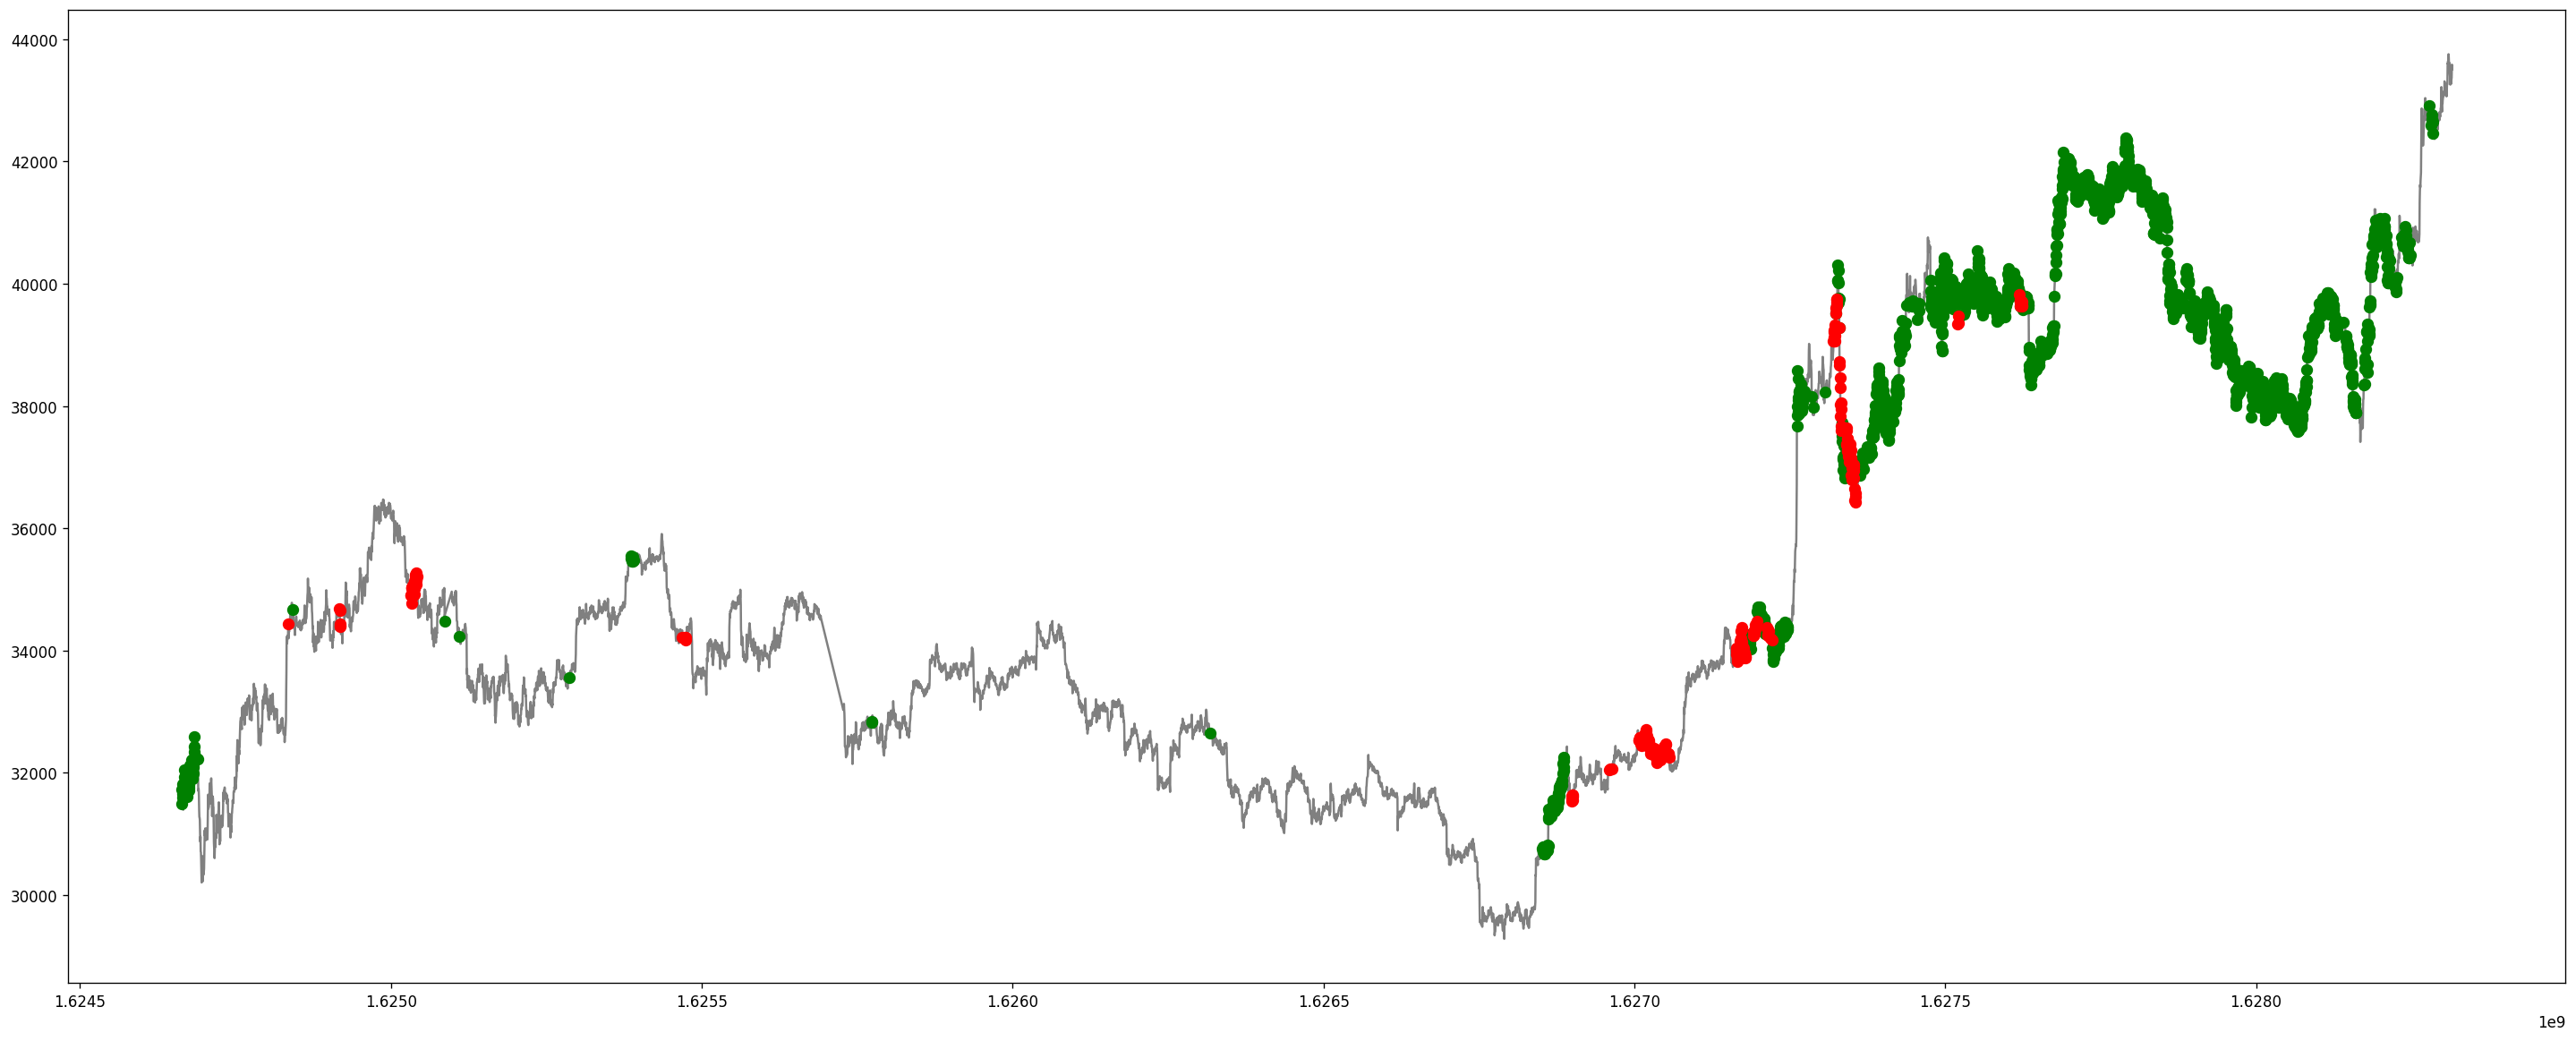

In [8]:
# сначала нарисуем результаты всех моделей на одном графике
magic(1)

✅️ Получено 10000 свечей (история BTC/USD да последние 40 дней). Последняя свеча открылась в 05:48 07-08-2021 (UTC).
🔴 красная точка - прогноз вниз,
🟢 зеленая точка - прогноз вверх.

Всего сигналов: 1015 (выиграл:503, проиграл:512), выиграл: 49.6%




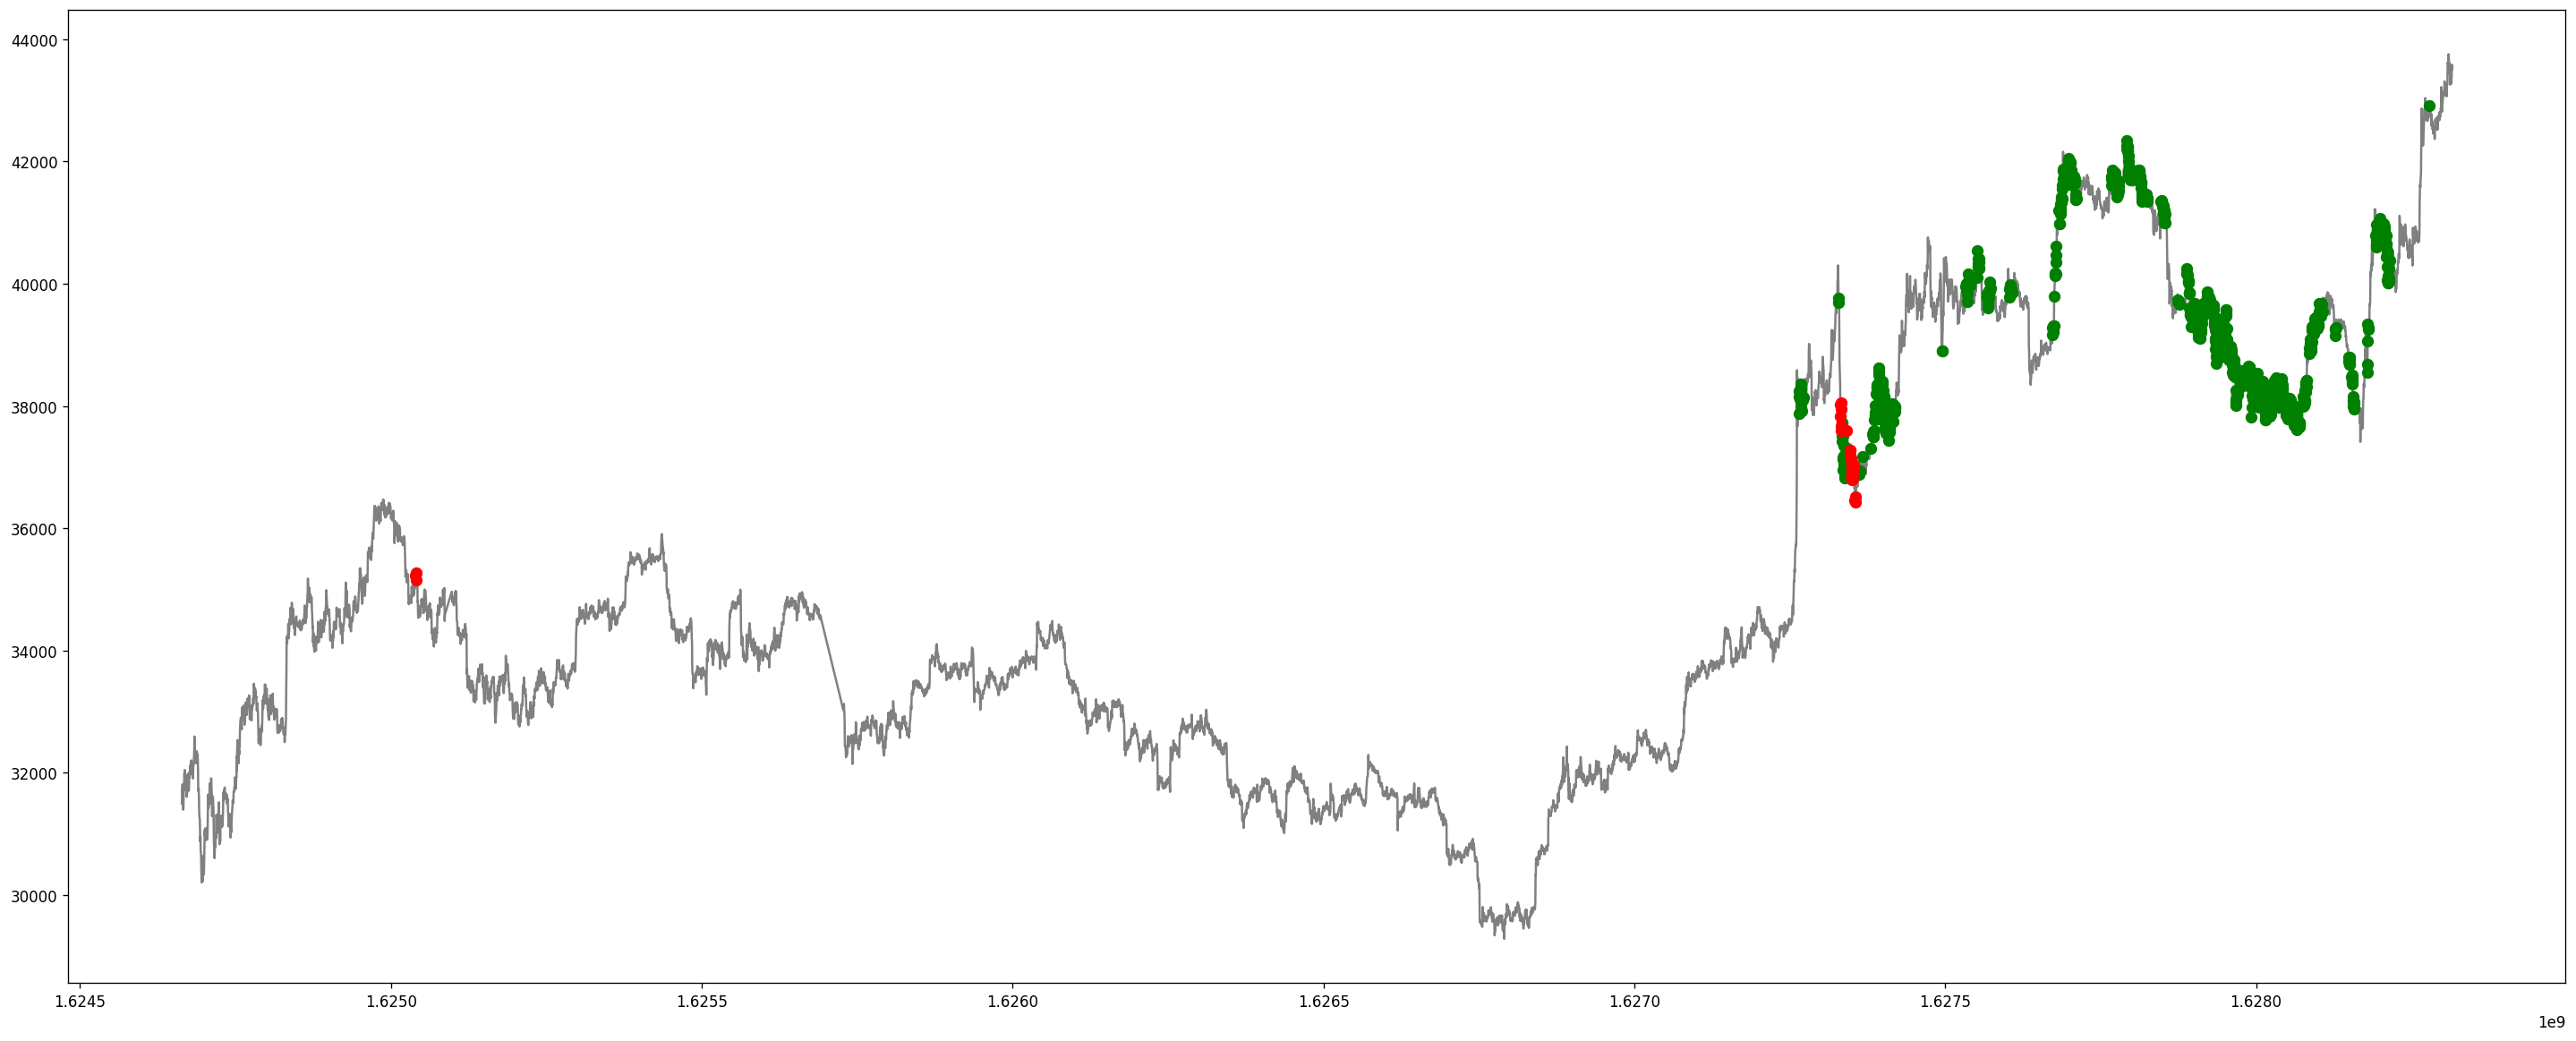

In [9]:
# теперь сигналы будут только если одновременно совпадет мнение двух и более моделей
magic(2)

✅️ Получено 10000 свечей (история BTC/USD да последние 40 дней). Последняя свеча открылась в 05:48 07-08-2021 (UTC).
🔴 красная точка - прогноз вниз,
🟢 зеленая точка - прогноз вверх.

Модель №1: всего сигналов: 1114 (выиграл:591, проиграл:523), выиграл: 53.1%
Модель №2: всего сигналов: 839 (выиграл:445, проиграл:394), выиграл: 53.0%
Модель №3: всего сигналов: 2042 (выиграл:1024, проиграл:1018), выиграл: 50.1%
Модель №4: всего сигналов: 55 (выиграл:33, проиграл:22), выиграл: 60.0%
Модель №5: всего сигналов: 205 (выиграл:111, проиграл:94), выиграл: 54.1%




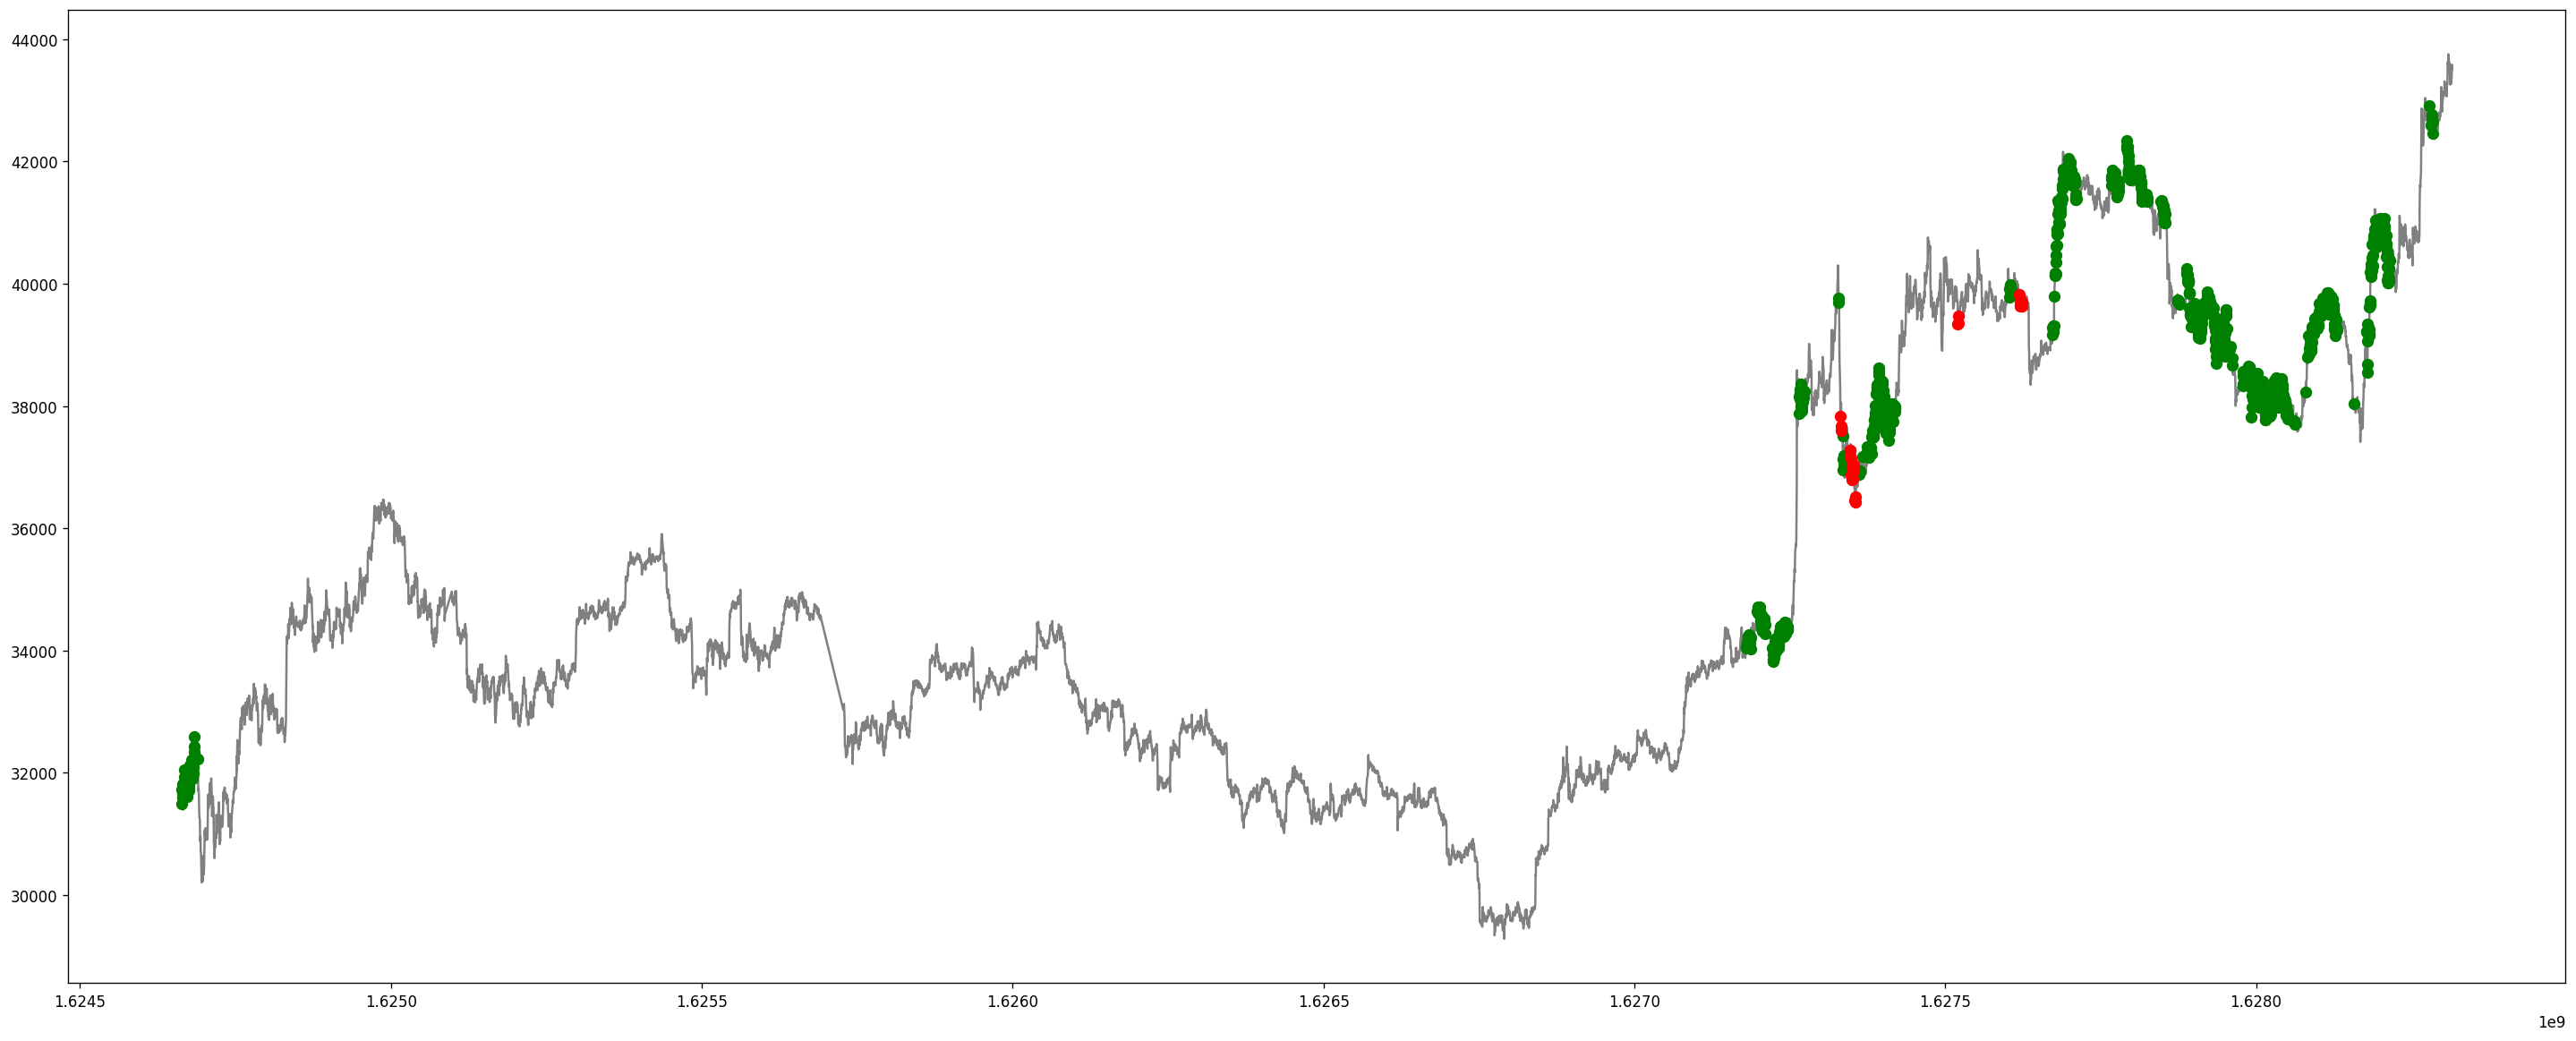

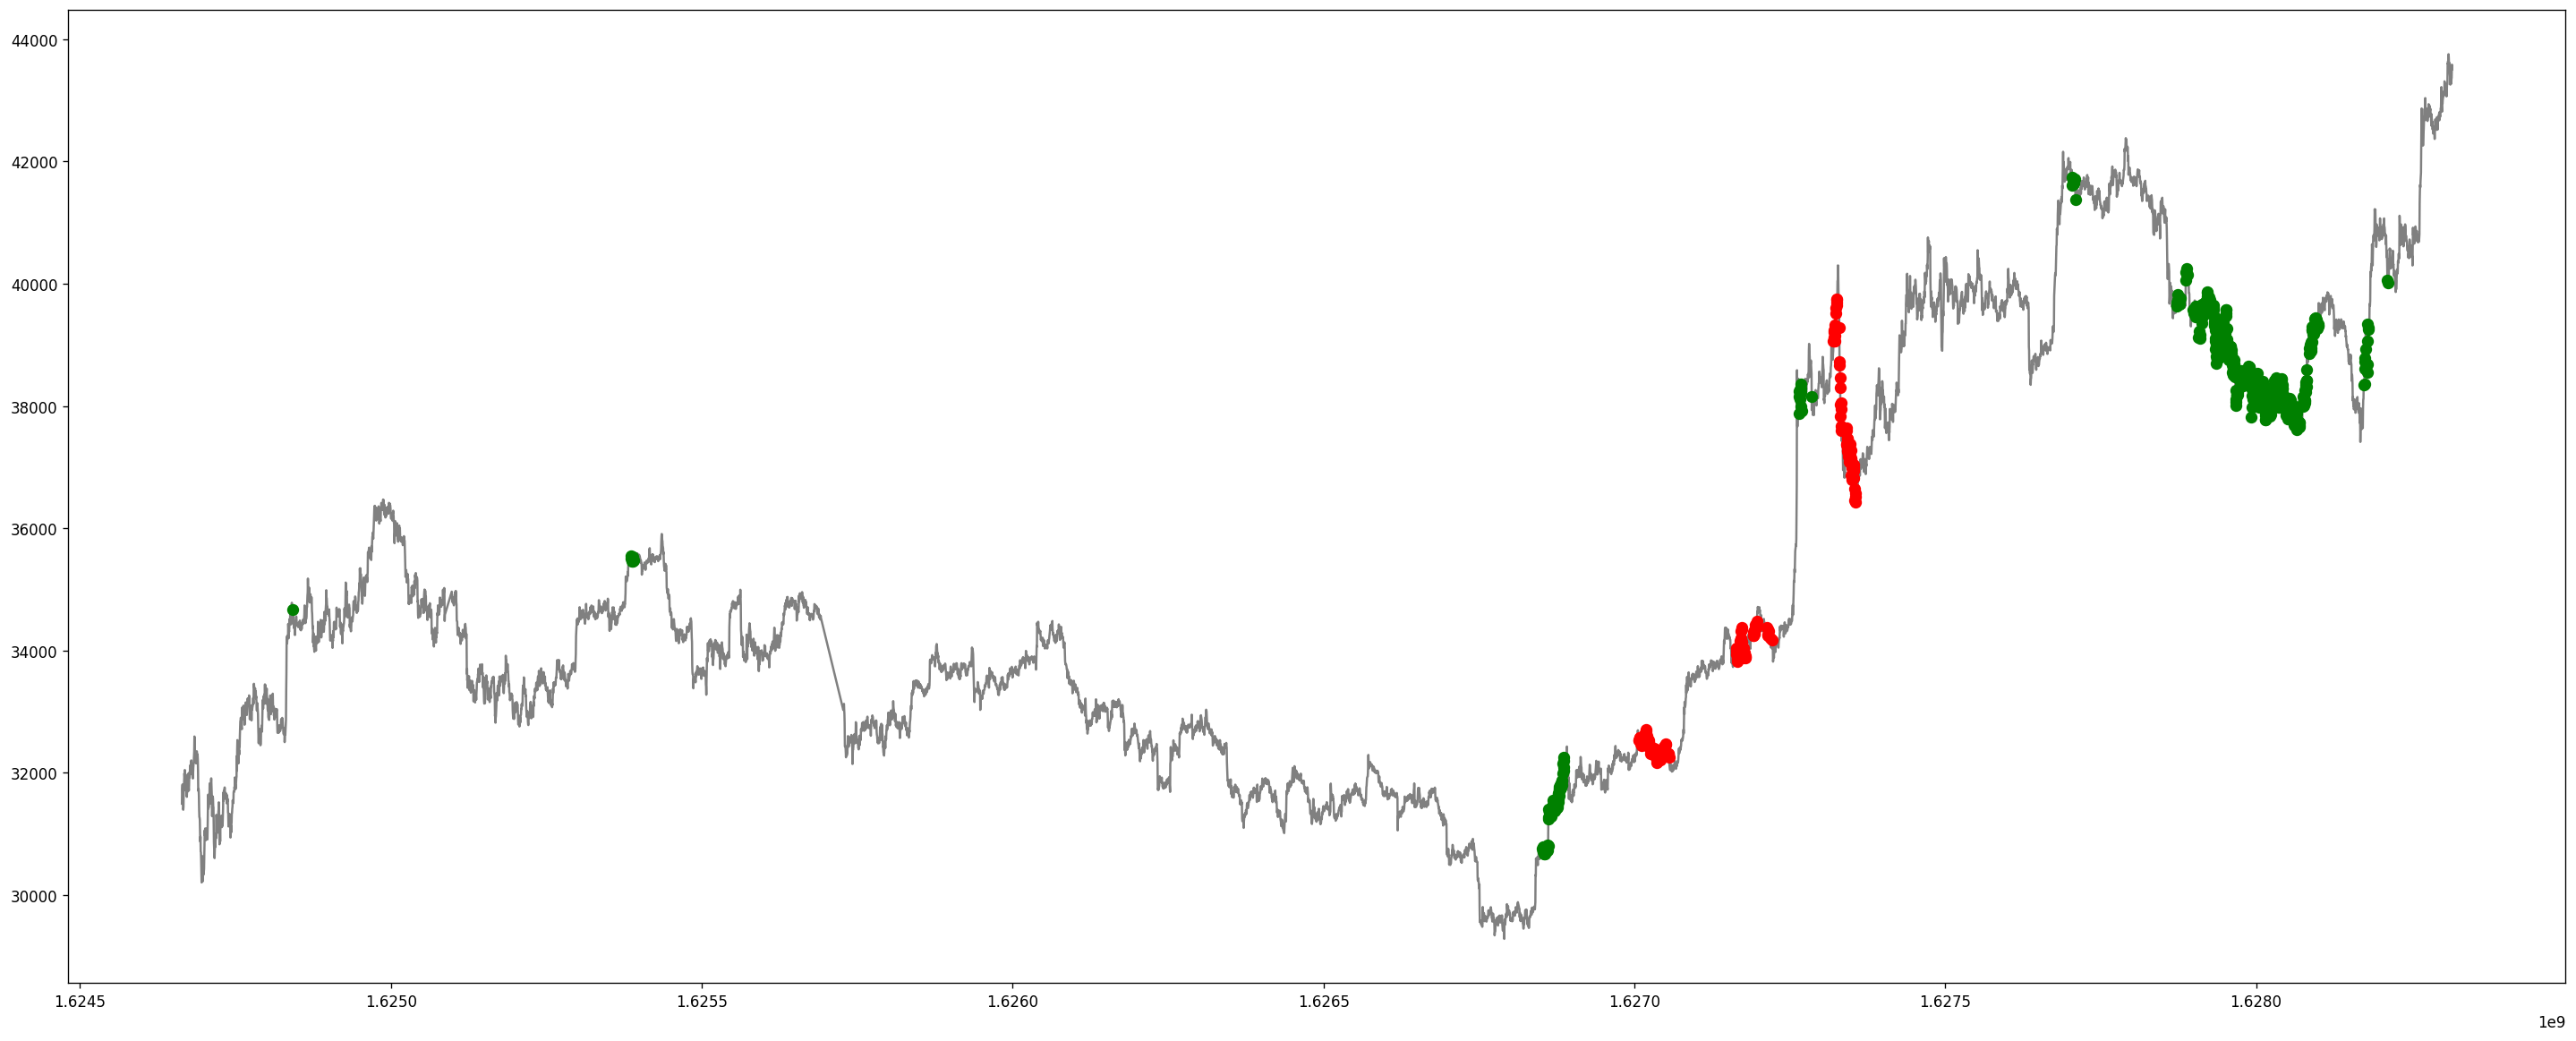

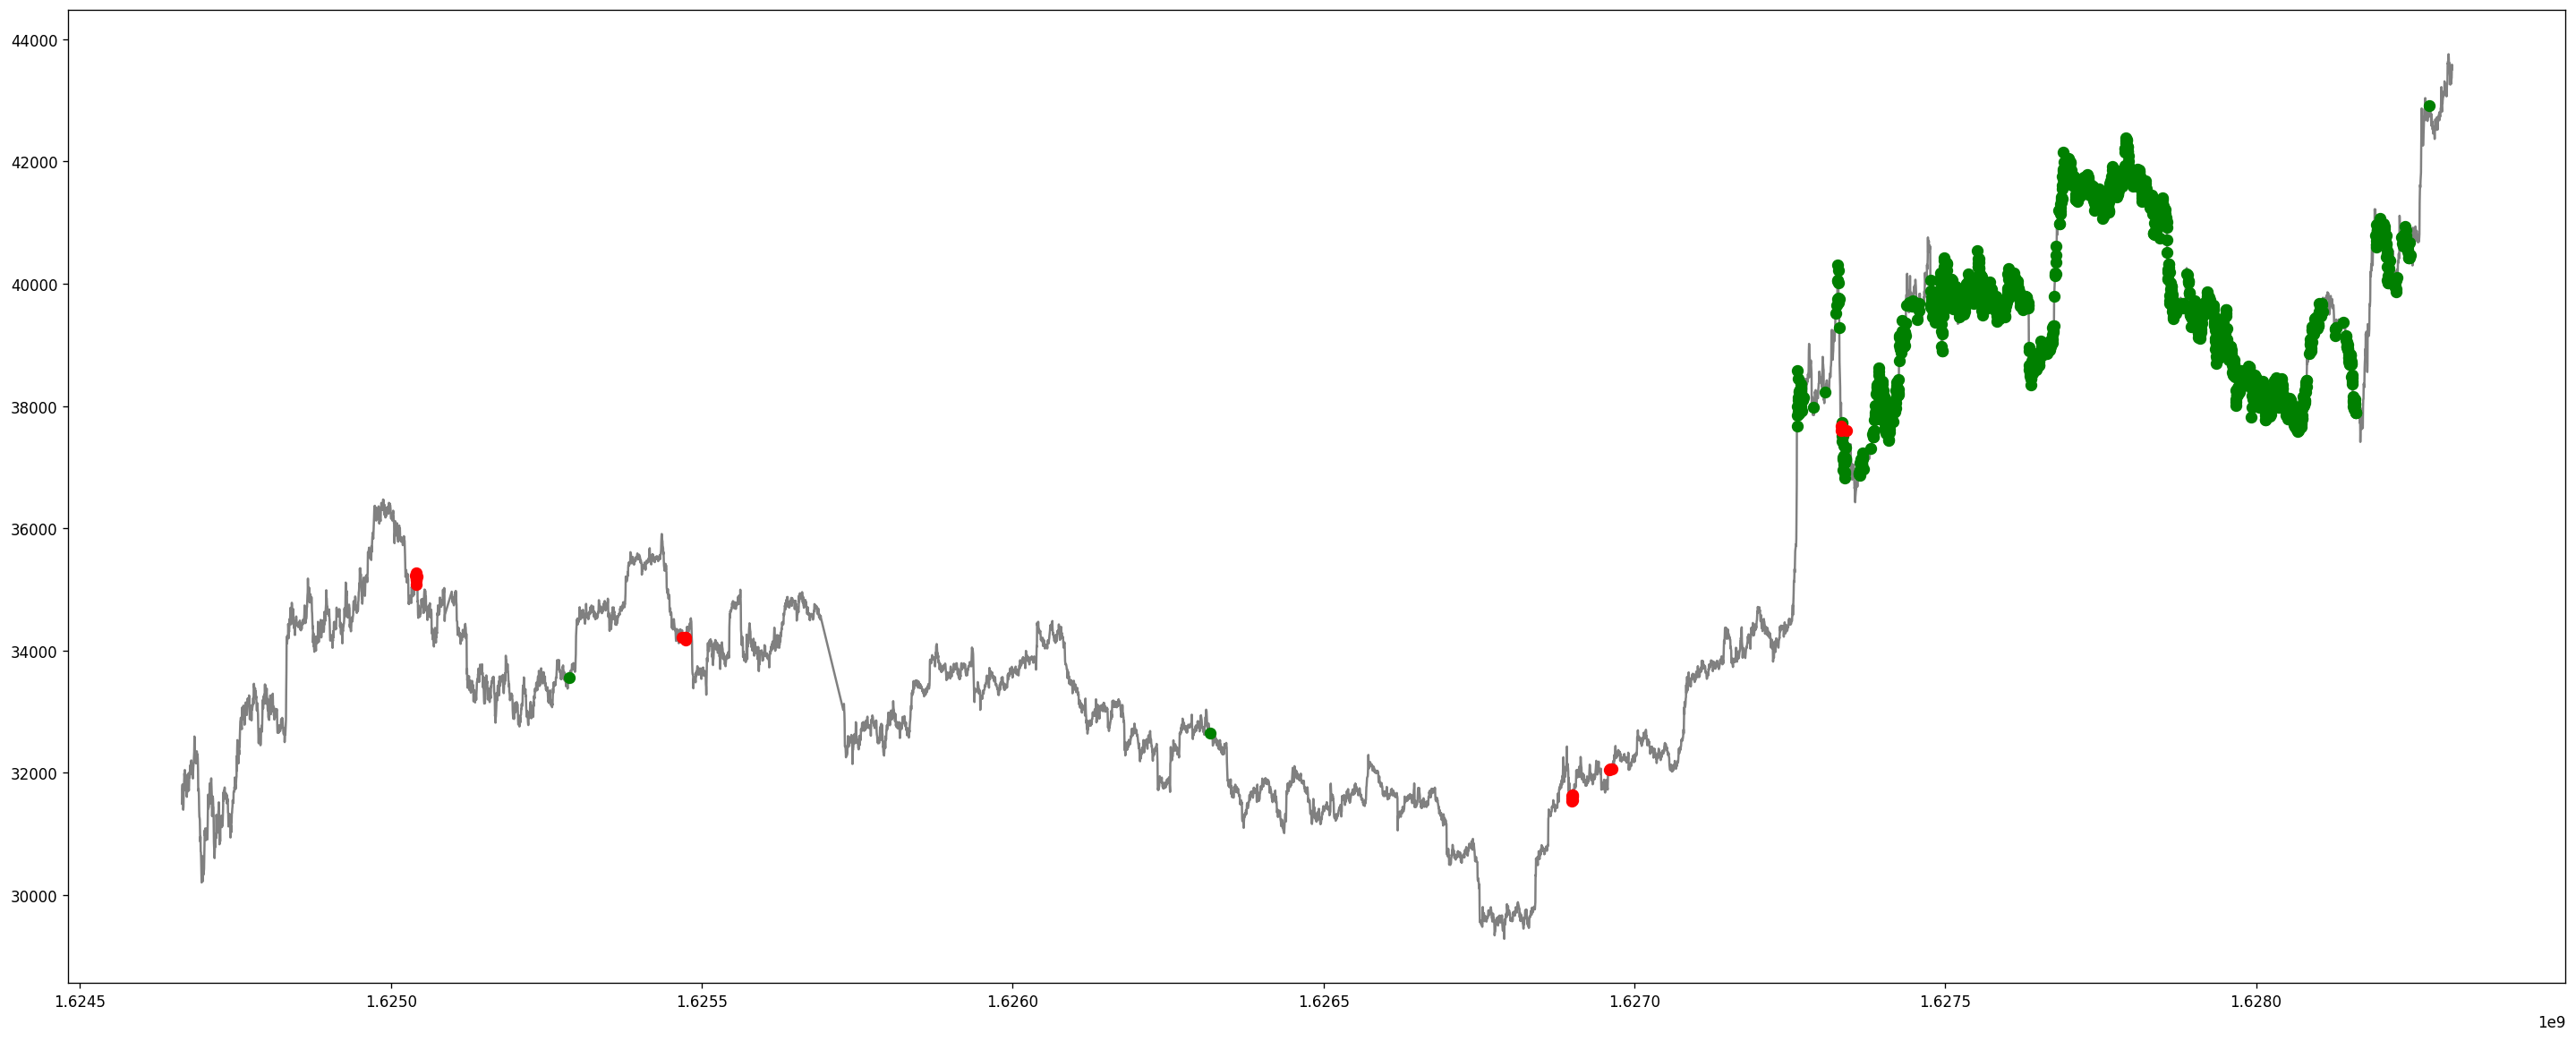

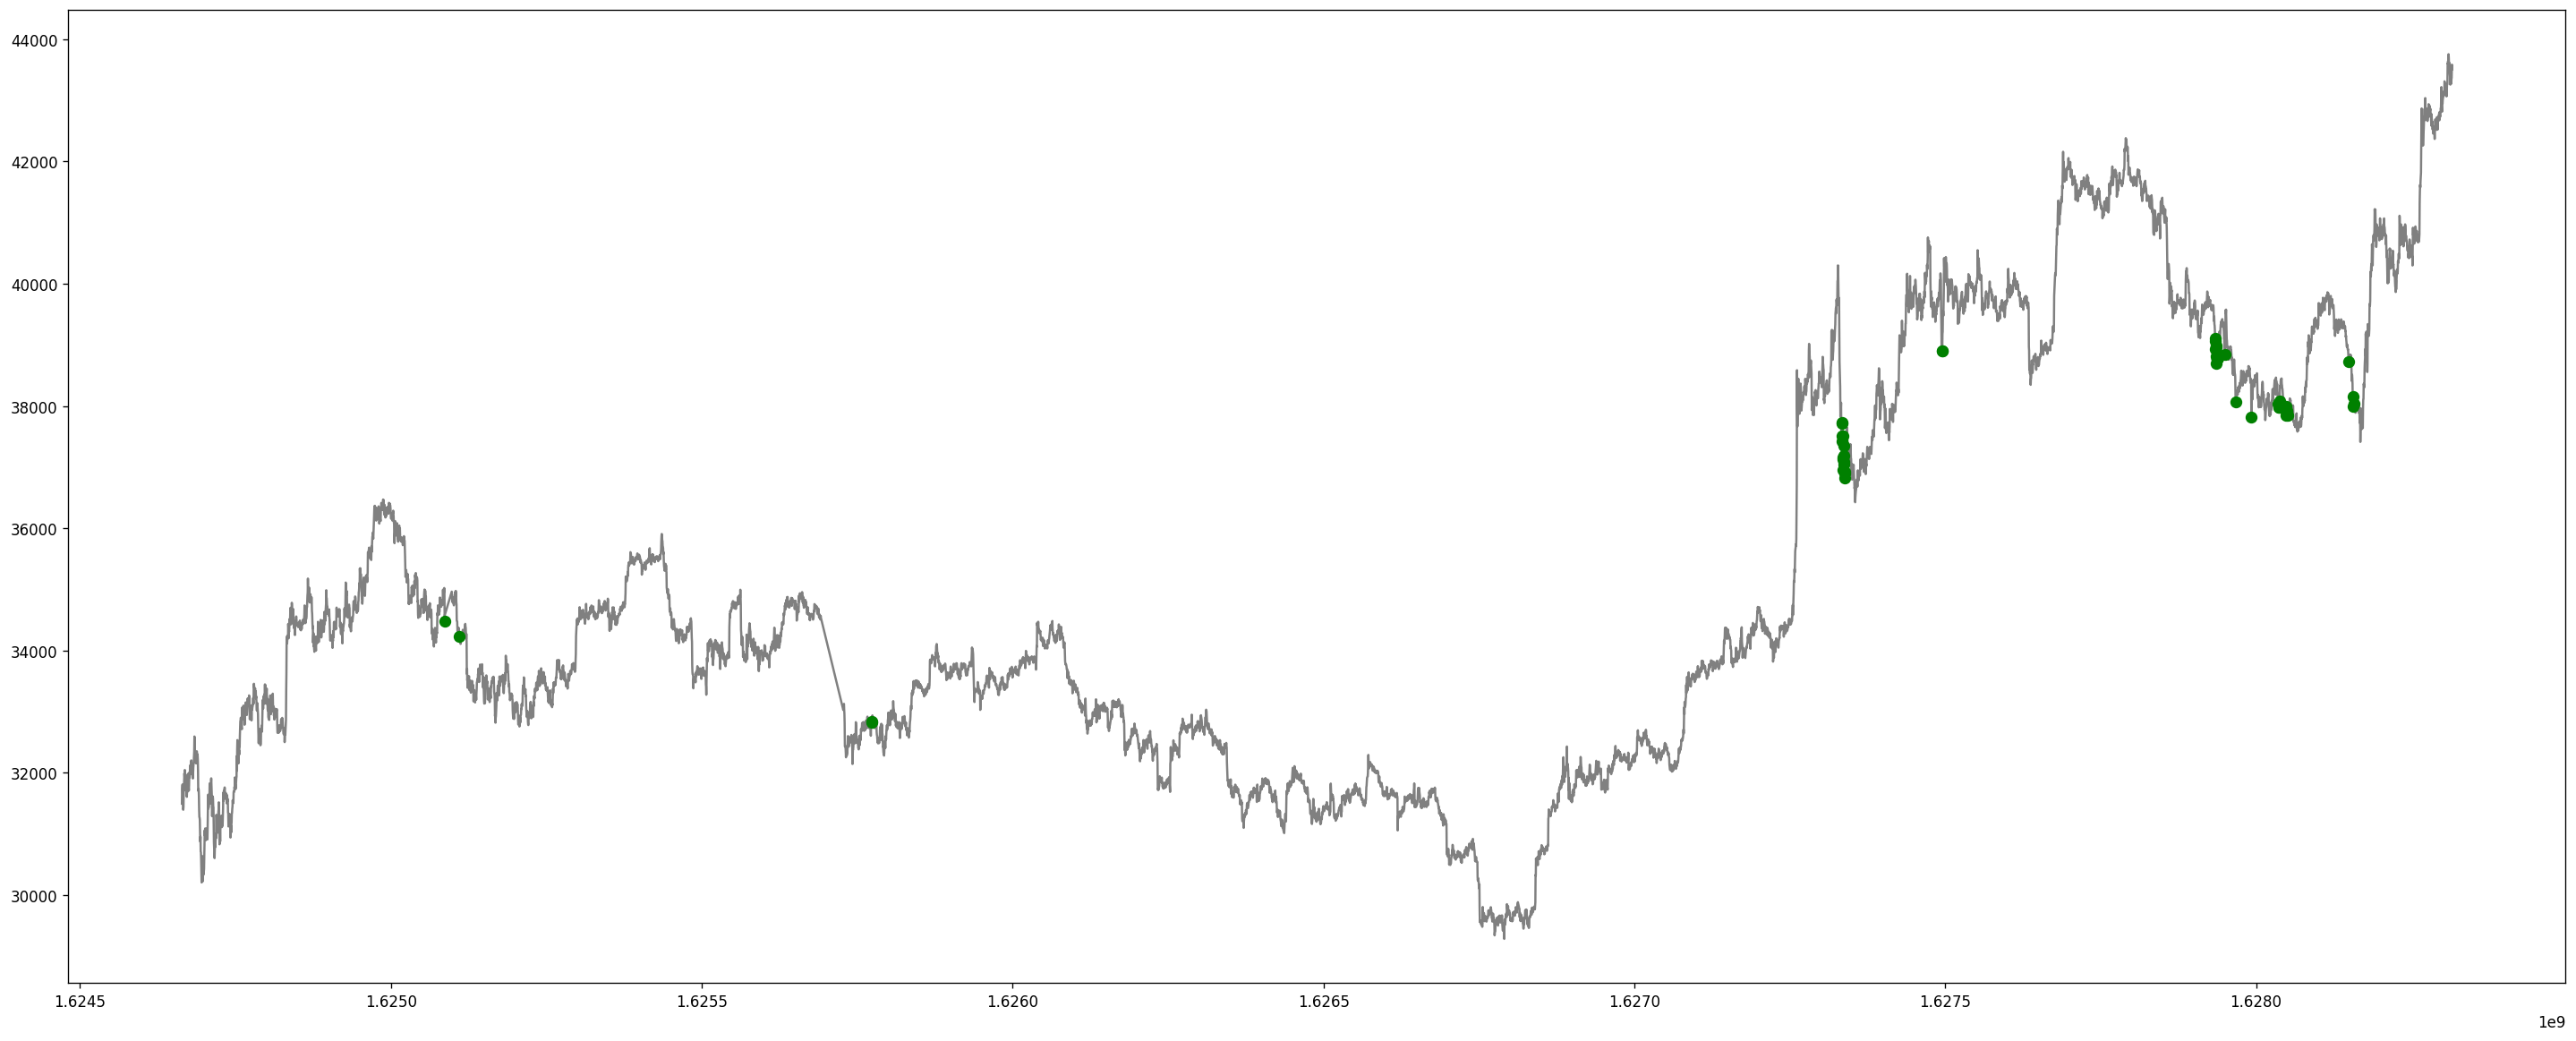

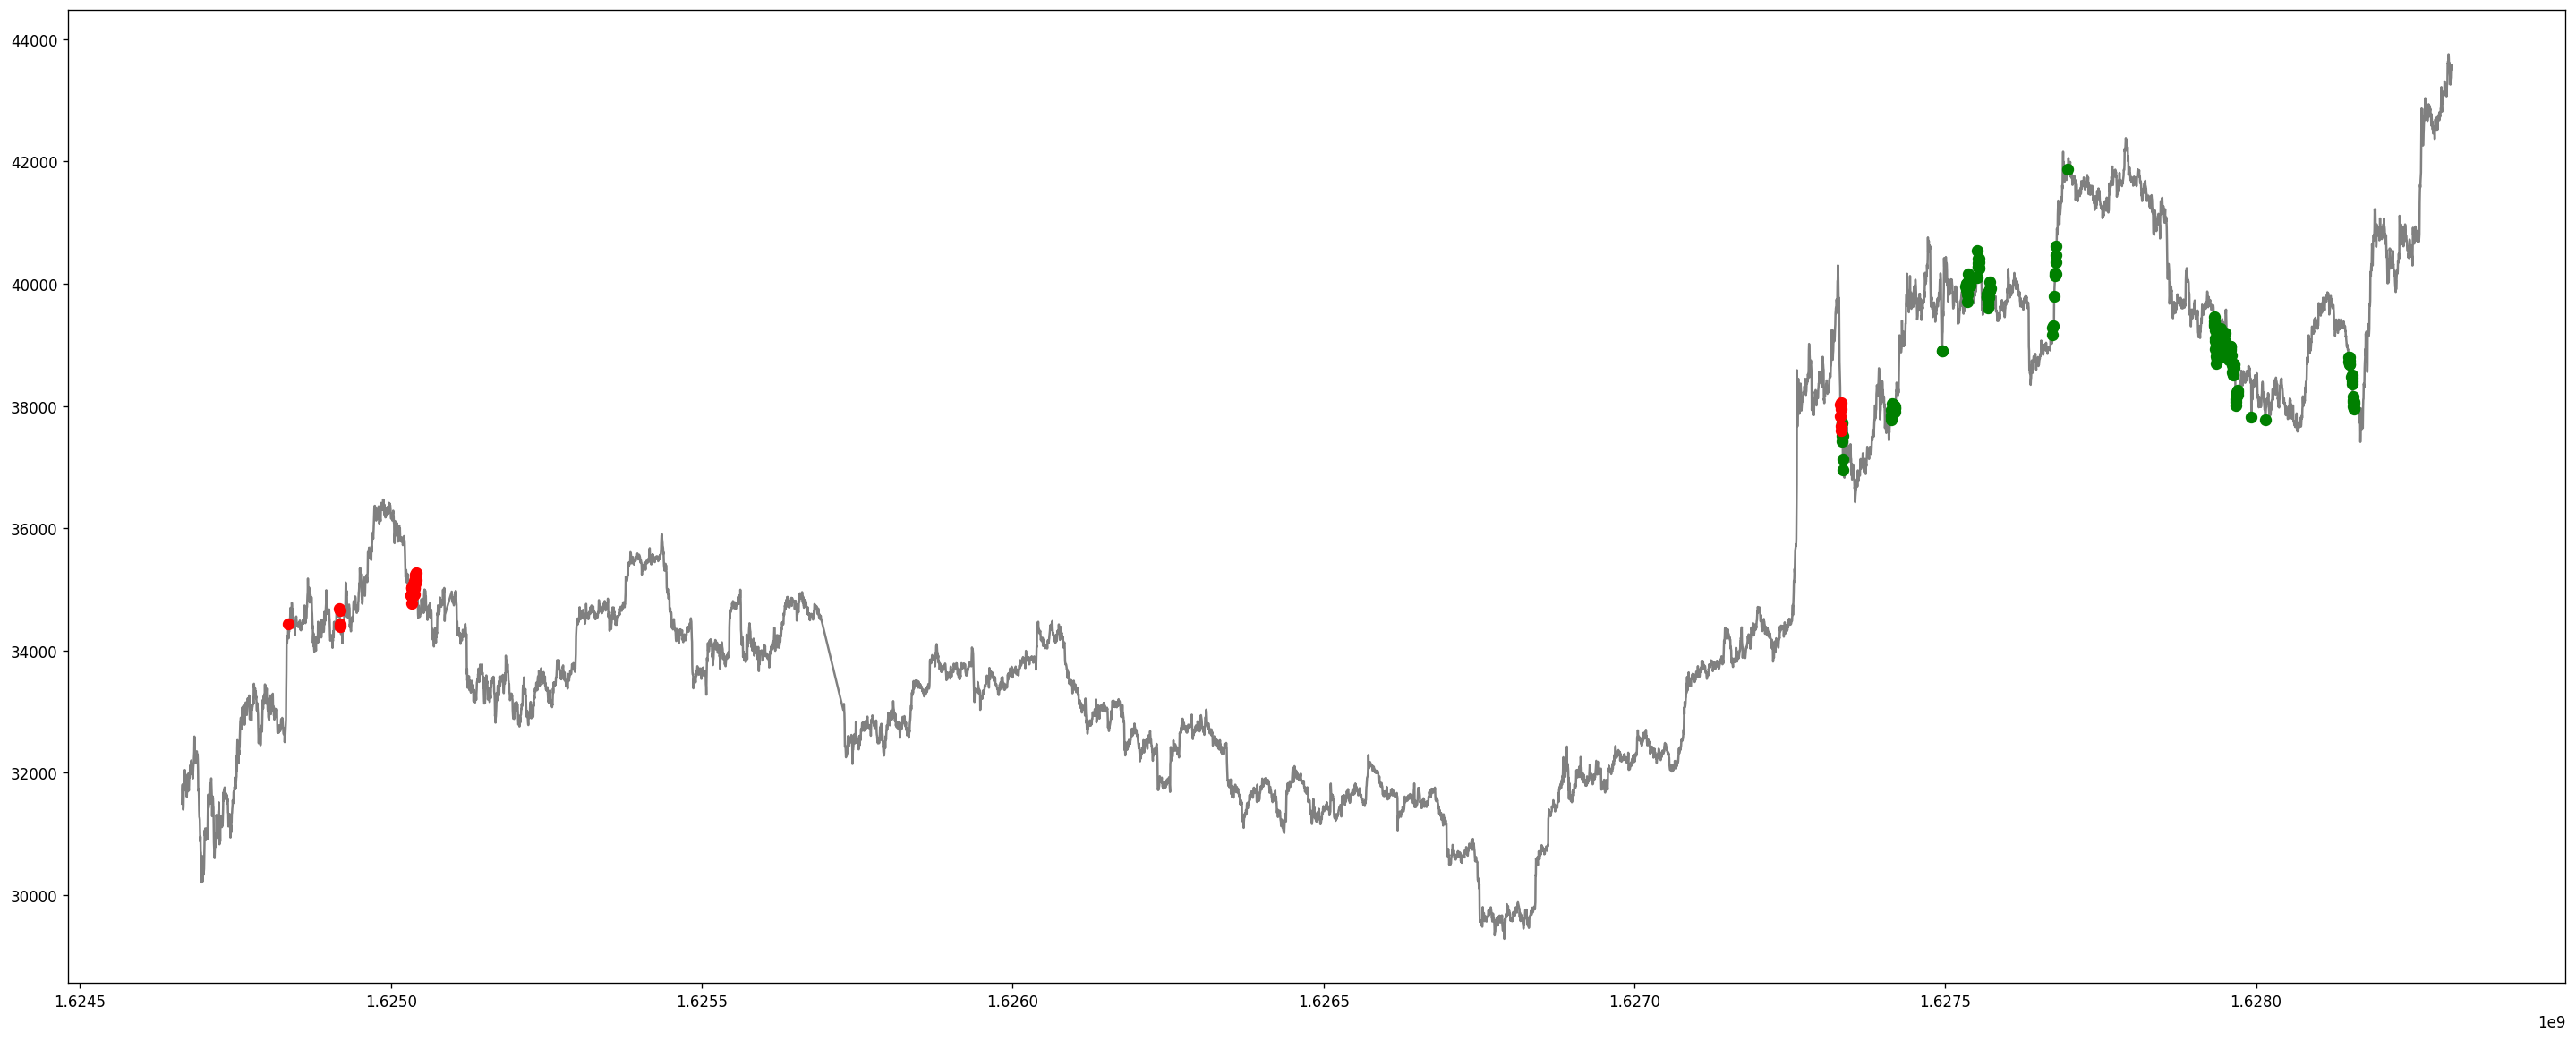

In [10]:
# а здесь у каждой модели будет свой результат и свой график
magic(0)

In [11]:
# если вы хотите убедиться в том, что модели не меняются со временем, скачайте их и,
# спустя несколько дней когда обновится график, положите архив в /content и запустите colab
files.download("/content/models.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>